# Pose Estimation across Object Using Nerf and DINO

## Import Everything

In [11]:
import torch
import numpy as np
import open3d as o3d
import torch.nn.functional as F
import torch.nn as nn
from pytorch3d.transforms import rotation_6d_to_matrix, matrix_to_rotation_6d
import math
import os
import gc
import cv2
import re
import matplotlib.pylab as plt
import json
from pyhocon import ConfigFactory
import typing
import warnings
import torchvision.transforms as T
import tqdm

from models.fields import RenderingNetwork, SDFNetwork, SingleVarianceNetwork, NeRF, FeatureNetwork, FeatureField
from models.renderer import NeuSRenderer, MeanRenderer, select_vertices_and_update_triangles
from reconstruct.optimizer import Optimizer
from reconstruct.utils import color_table, set_view, get_configs

# from models.features.clip_extract import CLIPArgs, extract_clip_features
from models.features.dino_extract import DINOArgs, extract_dino_features
from models.features.pca_colormap import apply_pca_colormap
from models.dataset_mvdiff import expand_features

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def split_underscore(input_str):
    # split the input string into the last part and the rest by underscore
    end = input_str.split('_')[-1]
    rest = '_'.join(input_str.split('_')[:-1])
    return rest, end


def load_checkpoint(case_name, checkpoint_fname):
    # read network config
    conf_path = './confs/wmask_ar.conf'
    f = open(conf_path)
    conf_text = f.read()
    conf_text = conf_text.replace('CASE_NAME', case_name) 
    f.close()
    conf = ConfigFactory.parse_string(conf_text)
    anneal_end = conf.get_float('train.anneal_end', default=0.0)

    # load feature field
    checkpoint = torch.load(os.path.join(checkpoint_fname), map_location='cuda')

    nerf_outside = NeRF(**conf['model.nerf']).to(device)
    sdf_network = SDFNetwork(**conf['model.sdf_network']).to(device)
    deviation_network = SingleVarianceNetwork(**conf['model.variance_network']).to(device)
    color_network = RenderingNetwork(**conf['model.rendering_network']).to(device)
    feature_network = FeatureField(**conf['model.feature_field']).to(device)
    feature_render = MeanRenderer()

    nerf_outside.load_state_dict(checkpoint['nerf'])
    sdf_network.load_state_dict(checkpoint['sdf_network_fine'])
    deviation_network.load_state_dict(checkpoint['variance_network_fine'])
    color_network.load_state_dict(checkpoint['color_network_fine'])
    feature_network.load_state_dict(checkpoint['feature_network'])
    renderer = NeuSRenderer(
        nerf_outside, sdf_network, deviation_network, color_network, feature_network, feature_render,**conf['model.neus_renderer']
    )

    print(f"loaded checkpoint from {checkpoint_fname}")
    return renderer, anneal_end


# def extract_features_from_img(image_fnames: list, feat_type: str, visualize=False):

#     """Extract features with support for caching.
#     return features
#     """
#     feat_type_to_extract_fn = {
#     "CLIP": extract_clip_features,
#     "DINO": extract_dino_features,
#     }

#     if feat_type == "CLIP":
#         raise NotImplementedError
    
#     extract_fn = feat_type_to_extract_fn[feat_type]

#     # Cache is invalid or doesn't exist, so extract features
#     print(f"Extracting {feat_type} features for {len(image_fnames)} images...")
#     features = extract_fn(image_fnames, device='cuda')
    
#     if visualize == True:
#         feature_pca = []
#         for feature in features:
#             feature_pca.append(apply_pca_colormap(feature).cpu().numpy())
#         plt.figure()
#         plt.suptitle("Visualize extracted PCA features")

#         for i, (image_path, dino_pca_) in enumerate(zip(image_fnames, feature_pca)):
#             plt.subplot(2, len(image_fnames), i + 1)
#             plt.imshow(cv2.imread(image_path)[..., [2,1,0]])
#             plt.title(os.path.basename(image_path))
#             plt.axis("off")

#             plt.subplot(2, len(image_fnames), len(image_fnames) + i + 1)
#             plt.imshow(dino_pca_)
#             plt.axis("off")

#         plt.tight_layout()
#         plt.savefig("demo_extract_features.png")
#         print("Saved plot to demo_extract_features.png")
#         plt.show()
    

#     return features


def Rx_random():
    theta = np.random.uniform(-np.pi/3, np.pi/3)
    return torch.tensor([
        [1, 0, 0, 0],
        [0, np.cos(theta), -np.sin(theta), 0],
        [0, np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32)


def RT_opengl2opencv(RT):
    """convert between opengl and opencv coordinate convention"""
    R = RT[:3, :3]
    t = RT[:3, 3]

    R_bcam2cv = np.asarray([[1, 0, 0], [0, -1, 0], [0, 0, -1]], np.float32)

    R_world2cv = R_bcam2cv @ R
    t_world2cv = R_bcam2cv @ t

    RT = np.concatenate([R_world2cv,t_world2cv[:,None]],1)

    return RT


def unproj_map(width, height, f, c=None, device="cpu"):
    """
    Get camera unprojection map for given image size.
    [y,x] of output tensor will contain unit vector of camera ray of that pixel.
    :param width image width
    :param height image height
    :param f focal length, either a number or tensor [fx, fy]
    :param c principal point, optional, either None or tensor [fx, fy]
    if not specified uses center of image
    :return unproj map (height, width, 3)
    """
    if c is None:
        c = [width * 0.5, height * 0.5]
    else:
        c = c.squeeze()
    if isinstance(f, float):
        f = [f, f]
    elif len(f.shape) == 0:
        f = f[None].expand(2)
    elif len(f.shape) == 1:
        f = f.expand(2)
    Y, X = torch.meshgrid(
        torch.arange(height, dtype=torch.float32) - float(c[1]),
        torch.arange(width, dtype=torch.float32) - float(c[0]),
    )
    X = X.to(device=device) / float(f[0])
    Y = Y.to(device=device) / float(f[1])
    Z = torch.ones_like(X)
    unproj = torch.stack((X, -Y, -Z), dim=-1)
    unproj /= torch.norm(unproj, dim=-1).unsqueeze(-1)
    return unproj

#TODO understand this function
def get_cos_anneal_ratio(iter_step):
    if anneal_end == 0.0:
        return 1.0
    else:
        return np.min([1.0, iter_step / anneal_end])


def gen_rays(poses, width, height, focal, z_near, z_far, c=None, ndc=False):
    """
    Generate camera rays
    :return (B, H, width, 8)
    ndc: Normalized Device Coordinates
    """
    num_images = poses.shape[0]
    device = poses.device
    cam_unproj_map = (
        unproj_map(width, height, focal.squeeze(), c=c, device=device)
        .unsqueeze(0)
        .repeat(num_images, 1, 1, 1)
    )
    cam_centers = poses[:, None, None, :3, 3].expand(-1, height, width, -1)
    cam_raydir = torch.matmul(
        poses[:, None, None, :3, :3], cam_unproj_map.unsqueeze(-1)
    )[:, :, :, :, 0]

    if ndc:
        if not (z_near == 0 and z_far == 1):
            warnings.warn(
                "dataset z near and z_far not compatible with NDC, setting them to 0, 1 NOW"
            )
        z_near, z_far = 0.0, 1.0
        cam_centers, cam_raydir = ndc_rays(
            width, height, focal, 1.0, cam_centers, cam_raydir
        )

    cam_nears = (
        torch.tensor(z_near, device=device)
        .view(1, 1, 1, 1)
        .expand(num_images, height, width, -1)
    )
    cam_fars = (
        torch.tensor(z_far, device=device)
        .view(1, 1, 1, 1)
        .expand(num_images, height, width, -1)
    )
    return torch.cat(
        (cam_centers, cam_raydir, cam_nears, cam_fars), dim=-1
    )  # (B, H, W, 8)


def gen_rays_from_a_view(poses, width, height, resolution_level=1):
    """
    poses: (B, 3, 4)    
    Generate rays at world space from one camera.
    """
    tx = torch.linspace(0, width, width)
    ty = torch.linspace(0, height, height)
    pixels_x, pixels_y = torch.meshgrid(tx, ty)
    pixels_x = pixels_x.reshape(-1).float()
    pixels_y = pixels_y.reshape(-1).float()

    q = torch.stack([(pixels_x/width-0.5)*2, (pixels_y/height-0.5)*2, torch.zeros_like(pixels_y)], dim=-1) # WxH, 3
    v = torch.stack([torch.zeros_like(pixels_y), torch.zeros_like(pixels_y), torch.ones_like(pixels_y)], dim=-1) # WxH, 3

    # orthogonal projection
    rays_v = v / torch.linalg.norm(v, ord=2, dim=-1, keepdim=True)  # WxH, 3 
    # print(rays_v.shape)
    if len(poses.shape) == 2: # (3,4) to (1,3,4)
        poses = poses.unsqueeze(0)
    rays_v = torch.matmul(poses[:, :3, :3].cuda(), rays_v[None, :, :].transpose(1,2).cuda())
    rays_v = rays_v.transpose(1,2) # B, WxH, 3
    
    rays_o = torch.matmul(poses[:,:3, :3].cuda(), q[None, :, :].transpose(1,2).cuda())  #B, 3, WxH 
    rays_o = rays_o.transpose(1,2) # B, WxH, 3
    rays_o = poses[:, :3, 3].unsqueeze(1).expand(rays_v.shape).cuda() + rays_o   # batch_size, 3
    rays = torch.cat([rays_o, rays_v], dim=-1)    # batch_size, 6
    return rays


def inv_RT(RT):
    RT_h = np.concatenate([RT, np.array([[0,0,0,1]])], axis=0)
    RT_inv = np.linalg.inv(RT_h)

    return RT_inv[:3, :]


def rgb2bgr(img_rgb):
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    return img_bgr


def show_img(title, img_rgb):  # img - rgb image
    # img_bgr = rgb2bgr(img_rgb)
    cv2.imshow(title, img_rgb)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def find_POI(img_rgb, DEBUG=False): # img - RGB image in range 0...255
    img = np.copy(img_rgb)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(img_gray, None)
    if DEBUG:
        img = cv2.drawKeypoints(img_gray, keypoints, img)
        show_img("Detected points", img)
    xy = [keypoint.pt for keypoint in keypoints]
    xy = np.array(xy).astype(int)
    # Remove duplicate points
    xy_set = set(tuple(point) for point in xy)
    xy = np.array([list(point) for point in xy_set]).astype(int)
    return xy # pixel coordinates


# 1d 2d convert
def flatten_position(row, col, width):
    return row * width + col


def unflatten_position(index, width):
    row = index // width
    col = index % width
    return row, col


def visualize_sampling_area(img, roi):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for point in roi:
        cv2.circle(img, (point[0], point[1]), 1, (0, 0, 255), -1)
    show_img("ROI", img)


def generate_SE3_noise(cam_pose, amplitude=0.1):
    """
    Generate SE3 noise for camera pose
    """
    se3_noise = torch.randn(cam_pose.shape[0],6,device=cam_pose.device)*amplitude
    SE3_noise = Lie().se3_to_SE3(se3_noise)
    SE3_noise = torch.cat([SE3_noise, torch.tensor([[[0, 0, 0, 1]]], device=SE3_noise.device).repeat(SE3_noise.shape[0], 1, 1)], dim=1)
    return SE3_noise


def compose_pair(pose_a,pose_b):
    # pose_new(x) = pose_b o pose_a(x)
    R_a,t_a = pose_a[...,:3,:3],pose_a[...,:3,3:]
    R_b,t_b = pose_b[...,:3,:3],pose_b[...,:3,3:]
    R_new = R_b@R_a
    t_new = (R_b@t_a+t_b)[...,0]
    pose_new = torch.eye(4).unsqueeze(0).repeat(pose_a.shape[0],1,1)
    pose_new[...,:3,:3] = R_new
    pose_new[...,:3, 3] = t_new
    return pose_new


cam_pose_dir = '/home/stud/zanr/code/tmp/Wonder3D/instant-nsr-pl/datasets/fixed_poses'
pose_fpath_dict = {
    '0':f'{cam_pose_dir}/000_front_left_RT.txt',
    '1':f'{cam_pose_dir}/000_front_RT.txt',
    '2':f'{cam_pose_dir}/000_right_RT.txt',
    '3':f'{cam_pose_dir}/000_top_RT.txt',
    '4':f'{cam_pose_dir}/000_front_right_RT.txt',
    '5':f'{cam_pose_dir}/000_back_RT.txt',
    '6':f'{cam_pose_dir}/000_back_right_RT.txt',
    '7':f'{cam_pose_dir}/000_left_RT.txt',
    '8':f'{cam_pose_dir}/000_back_left_RT.txt'
    }

DEBUG = False

In [12]:
# load the feature network
obj_name = 'owl'
ckpt_path = './exp/neus/'+ obj_name +'/checkpoints/ckpt_003000.pth'
print(ckpt_path)
renderer, anneal_end = load_checkpoint(obj_name, ckpt_path)


# extract DINO features
# target_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/outputs/cropsize-192-cfg1.0/owl/rgb/rgb_000_front_right.png'
# input_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/outputs/cropsize-192-cfg1.0/owl/rgb/rgb_000_front_left.png'

# target_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/NeuS/outputs/rendered_img_4.png' # rendered from pose 4
# input_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/outputs/cropsize-192-cfg1.0/owl/rgb/rgb_000_front_left.png' # rendered use pose 3

# target_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/NeuS/outputs/rendered_img_0.png' # rendered from pose 0
# input_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/NeuS/outputs/rendered_img_1.png' # rendered use pose 1

target_img_fname = './outputs/rendered_img_8.png' # rendered from pose 4
input_img_fname = './outputs/rendered_img_6_noised.png' # rendered use pose 3

target_img = cv2.imread(target_img_fname, -1)
input_img = cv2.imread(input_img_fname, -1)
obj_mask = torch.from_numpy((target_img[:, :, 0] > 0)).float()



    
# normalize image -> between 0 and 1
target_img = (target_img / 255.0).astype(np.float32)    
input_img = (input_img / 255.0).astype(np.float32)

# visualization
if DEBUG:
    plt.imshow(target_img)
    plt.show()


# #------------------POI--------------------# 
# # # found the POI 
# # #TODO visualize the POI, checking if correct
# H, W = target_img.shape[:2]
# target_img = target_img.astype(np.uint8)
# POI = find_POI(target_img)
# # not_POI -> contains all points except of POI
# # create meshgrid from the observed image
# coords = np.asarray(np.stack(np.meshgrid(np.linspace(0, W - 1, W), np.linspace(0, H - 1, H)), -1),
#                     dtype=int)

# # create sampling mask for interest region sampling strategy
# interest_regions = np.zeros((H, W, ), dtype=np.uint8)
# interest_regions[POI[:,1], POI[:,0]] = 1
# # I = args.dil_iter
# I = 10
# kernel_size = 2
# interest_regions = cv2.dilate(interest_regions, np.ones((kernel_size, kernel_size), np.uint8), iterations=I)
# interest_regions = np.array(interest_regions, dtype=bool)
# interest_regions = coords[interest_regions]

# coords = coords.reshape(H * W, 2)
# not_POI = set(tuple(point) for point in coords) - set(tuple(point) for point in POI)
# not_POI = np.array([list(point) for point in not_POI]).astype(int)

# if DEBUG:
#     target_img_test = target_img.copy()
#     visualize_sampling_area(target_img_test, interest_regions)


# extract image features
feature_save_path = f'./outputs/target_features_{obj_name}.npy'

if os.path.exists(feature_save_path):
    target_img_features = np.load(feature_save_path)
    target_img_features = torch.from_numpy(target_img_features).to(device)
    target_img_features = target_img_features.unsqueeze(0) # 1, 128, 128, 384
    print(f"Loaded target features from cache {feature_save_path}")
else:
    target_img_features = extract_dino_features([target_img_fname], device)
    image_size = [in_sz, in_sz]
    target_img_features = expand_features(target_img_features, image_size)

    # save target_features
    target_features = target_img_features[0]
    # target_features = target_features.permute(1, 2, 0) # CHW to HWC
    target_features = target_features.cpu().numpy()
    np.save(feature_save_path, target_features)


./exp/neus/owl/checkpoints/ckpt_003000.pth
loaded checkpoint from ./exp/neus/owl/checkpoints/ckpt_003000.pth


## Kmeans

In [3]:
from sklearn.cluster import KMeans
n_clusters = 6

target_img_features_flatten = torch.reshape(target_img_features[0], [-1, target_img_features[0].shape[-1]])
target_img_features_flatten /= torch.norm(target_img_features_flatten, dim=-1, keepdim=True)
# cluster_centers = k_means(target_img_features_flatten.cpu().numpy(), k=10)    

target_img_features_pca = apply_pca_colormap(target_img_features[0]).cpu().numpy() # 128, 128, 3  
target_img_features_pca_flatten = np.reshape(target_img_features_pca, [-1, target_img_features_pca.shape[-1]]) #  128*128, 3
# cluster_centers = k_means(target_img_features_pca_flatten, k=10)

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(target_img_features_flatten.cpu().numpy())
cluster_labels = kmeans.labels_  # Shape: (128*128,)
cluster_centers = kmeans.cluster_centers_  # Shape: (k, 384)
cluster_labels_2d = cluster_labels.reshape(128, 128)

# Display the cluster labels as an image
plt.imshow(cluster_labels_2d, cmap='viridis')  # You can use any colormap you like
plt.colorbar()
plt.title("K-means Clustering of DINO Features")
plt.show()

# Compute the distance from each pixel to each cluster center
distances_to_centers = np.linalg.norm(target_img_features_flatten.cpu().numpy()[:, np.newaxis] - cluster_centers, axis=2)

# Find the pixel closest to each center
closest_pixels = np.argmin(distances_to_centers, axis=0)  # Shape: (k,)

# Convert the flattened indices back to 2D coordinates
closest_pixel_coords = np.unravel_index(closest_pixels, (128, 128))  # Shape: (2, k)


# Display the original image
plt.imshow(target_img_features_pca, cmap='gray')  # Assuming original_image is grayscale, otherwise remove cmap

# Overlay the cluster centers
plt.scatter(closest_pixel_coords[1], closest_pixel_coords[0], c='red', s=100, marker='x')  # 'x' marks for centers
plt.title("Cluster Centers on Original Image")
plt.show()


/home/stud/zanr/software/miniforget3/envs/wonder3d/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [4]:
def random_pts_around_centers(closest_pixel_coords, num_points, pt_range):
    random_points = []
    n_clusters = len(closest_pixel_coords[0])
    for i in range(n_clusters):
        # Get the coordinates
        x = closest_pixel_coords[0][i]
        y = closest_pixel_coords[1][i]

        # Generate random points around the given coordinates
        random_points_x = np.random.randint(x - pt_range, x + pt_range, num_points)
        random_points_y = np.random.randint(y - pt_range, y + pt_range, num_points)

        # Append the randomly selected points to the list
        for j in range(num_points):
            random_points.append((random_points_x[j], random_points_y[j]))
    return random_points

random_points = random_pts_around_centers(closest_pixel_coords, num_points=50, pt_range=15)
# Create a 128x128 grid
grid = [[0 for _ in range(128)] for _ in range(128)]

# Mark the generated points on the grid
for point in random_points:
    x, y = point
    grid[x][y] = 1

# Plot the grid
plt.imshow(grid, cmap='binary')
plt.imshow(target_img_features_pca, cmap='gray', alpha=0.5)
plt.scatter(closest_pixel_coords[1], closest_pixel_coords[0], c='red', s=100, marker='x')  # 'x' marks for centers
plt.title("Random Points on Original Image")

plt.show()

NameError: name 'results' is not defined

In [24]:
mesh = o3d.io.read_triangle_mesh(mesh_path)
mesh.compute_vertex_normals()
import open3d.visualization.rendering as rendering 

def mesh_render(mesh, img_width, img_height,extrinsic_mat):
    render = rendering.OffscreenRenderer(img_width, img_height)
    # pinhole_camera = o3d.camera.PinholeCameraIntrinsic(img_width, img_height, 150,150, img_width // 2, img_height // 2)
    render.scene.set_background([0, 0, 0, 0])
    material = rendering.MaterialRecord()
    render.scene.add_geometry('mesh', mesh, material)
    # render.scene.set_lighting(rendering.SunLight(intensity=5.0, azimuth=0, elevation=45))
    # render.setup_camera(pinhole_camera,extrinsic_mat)
    # render.setup_camera(60.0, [0, 0, 0], [0, 0, 2.0], [0, 0, 1]) # center: to look at, eye: camera position, up: camera up direction
    render.setup_camera(20.0, [0, 0, 0], extrinsic_mat[:3,3], [0, 0, 1]) # center: to look at, eye: camera position, up: camera up direction
    img_o3d = render.render_to_image()
    return img_o3d

def generate_circle_extrinsics(radius, num_views):
    extrinsics = []
    for i in range(num_views):
        theta = 2 * np.pi * i / num_views
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        z = 1.8

        extrinsic = np.eye(4)
        extrinsic[:3, 3] = [x, y, z]
        # pointing to the center
        direction = -np.array([x, y, z])
        direction /= np.linalg.norm(direction)
        up = np.array([0, 0, 1])
        right = np.cross(up, direction)
        right /= np.linalg.norm(right)
        up = np.cross(direction, right)
        extrinsic[:3, :3] = np.vstack([right, up, direction])
        extrinsics.append(extrinsic)
    return extrinsics


# def Rz(theta):
#     return np.array([
#         [np.cos(theta), -np.sin(theta), 0],
#         [np.sin(theta), np.cos(theta), 0],
#         [0, 0, 1]
#     ])

# extrinsic_matrix = np.eye(4)
# extrinsic_matrix[:3, 3] = np.array([0,0,1.8])
# extrinsic_matrix[:3, :3] = np.array([[0,0,-1],
#                                      [1,0,0],
#                                      [0,-1,0]])

# img_o3d = mesh_render(mesh, 256, 256, extrinsic_matrix)
# plt.imshow(np.asarray(img_o3d))
# plt.show()

extrinsics = generate_circle_extrinsics(5, 20)

image_paths = []

for idx, extrinsic in enumerate(extrinsics):

    img_o3d = mesh_render(mesh, 256, 256, extrinsic)
    # images.append(np.asarray(img_o3d))
    fpath = f'./exp/neus/{obj_name}/meshes/{obj_name}_render_view_{idx}.png'
    o3d.io.write_image(fpath, img_o3d)
    image_paths.append(fpath)

    # visualize
    # plt.imshow(np.asarray(img_o3d))
    # plt.show()



[Open3D INFO] EGL headless mode enabled.


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.


libEGL warning: DRI3: failed to query the version


FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


[Open3D INFO] EGL headless mode enabled.


libEGL warning: DRI3: failed to query the version


FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)


libEGL warning: DRI2: failed to authenticate
libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


EGL(1.5)
OpenGL(4.5)
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x563b6a142450 (threading is enabled)
EGL(1.5)
OpenGL(4.5)


libEGL warning: DRI3: failed to query the version
libEGL warning: DRI2: failed to authenticate


### Compare cos similarity directly and relative graph

In [25]:
# compare the directly cos similarity   
scores = []
img_features = extract_features_from_img(image_paths, "DINO", visualize=False) 

for img_feature in img_features:
    score = torch.dot(img_feature.flatten(), target_img_features.flatten())
    scores.append(score)    

Extracting DINO features for 20 images...
Loaded DINO model dino_vits8


Using cache found in /home/stud/zanr/.cache/torch/hub/facebookresearch_dino_main


Preprocessed 20 images to shape torch.Size([20, 3, 256, 256])


Extracting DINO features: 100%|██████████| 5/5 [00:00<00:00, 74.01it/s]

Extracted DINO embeddings of shape torch.Size([20, 63, 63, 384])


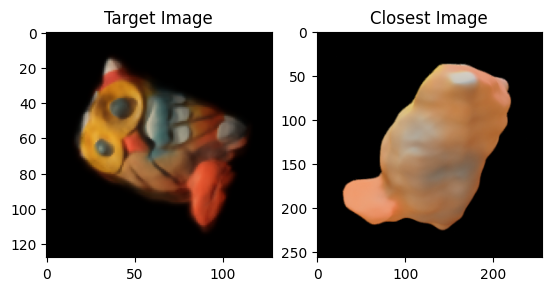

In [27]:
min_idx = torch.argmin(torch.FloatTensor(scores))
plt.subplot(1, 2, 1)
plt.imshow(target_img[...,[2,1,0]].cpu())
plt.title("Target Image")
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(image_paths[min_idx])[...,[2,1,0]])
plt.title("Closest Image")
plt.show()

# Training

In [30]:
# print(torch.var(target_img_features_flatten))
print(target_img_features_flatten.max(), target_img_features_flatten.min())
target_img_features_flatten_normalized = (target_img_features_flatten - torch.mean(target_img_features_flatten.min())) / (target_img_features_flatten.max()- target_img_features_flatten.min())
print(torch.std(target_img_features_flatten_normalized))
print(target_img_features_flatten_normalized.max(), target_img_features_flatten_normalized.min()) 
# target_img_features_flatten_normalized = (target_img_features_flatten - torch.mean(target_img_features_flatten)) / torch.std(target_img_features_flatten)
# print(torch.std(target_img_features_flatten_normalized))
# print(target_img_features_flatten_normalized.max(), target_img_features_flatten_normalized.min())

tensor(4.4452, device='cuda:0') tensor(-4.8881, device='cuda:0')
tensor(0.0611, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0')


In [45]:
# numpy to tensor
if type(target_img) != torch.Tensor:
    target_img = torch.from_numpy(target_img).float().to(device)
    input_img = torch.from_numpy(input_img).float().to(device)
in_sz = 128

target_img = target_img.permute(2, 0, 1) # HWC to CHW
input_img = input_img.permute(2, 0, 1) # HWC to CHW
target_img = T.Resize(in_sz)(target_img)
input_img = T.Resize(in_sz)(input_img)

target_img = target_img.permute(1, 2, 0) 
input_img = input_img.permute(1, 2, 0) # CHW to HWC

# flatten the image
target_img_flatten =torch.reshape(target_img, [-1, 3])  # (H*W, 3)
target_img_features_flatten = torch.reshape(target_img_features_expanded[0], [-1, 384])
target_img_features_flatten = (target_img_features_flatten -target_img_features_flatten.min()) / (target_img_features_flatten.max() - target_img_features_flatten.min()) # 128x128, 384
target_img_features_pca = apply_pca_colormap(target_img_features_expanded[0])
target_img_features_pca_flatten = torch.reshape(target_img_features_pca, [-1, 3])
# target_img_features_flatten = target_img_features_flatten / torch.norm(target_img_features_flatten, dim=1, keepdim=True) # 128x128, 384
# del target_img_features_expanded


# -------------------- Apply Noise----------------------#

# 1. apply random se3 noise


# 2.load pre-defined noisy poses (already rendered)
input_poses = np.load('noisy_poses_0.npy')
input_pose = torch.from_numpy(input_poses[5])
input_pose_r6d = Lie().SE3_to_se3(input_pose[:3,:]).unsqueeze(0)
input_pose_t = input_pose[:3,3]
print(f'input pose: {input_pose.shape}')
print(f'input pose r6d: {input_pose_r6d.shape}')

# cam_pose = torch.clone(input_pose.detach()).unsqueeze(0) # batch_sz, 3, 4
cam_r6d = torch.clone(input_pose_r6d.detach())
cam_r6d.requires_grad = True
print(f"Init pose: \n{cam_r6d[0]}")


# -------------------Optimization----------------------#

# Create optimizer. 
lrate = 1e-2 # TODO chang to args
optimizer = torch.optim.Adam(params=[cam_r6d], lr=lrate)
n_steps = 100 + 1

# z_near, z_far = args.z_near, args.z_far
# focal = torch.tensor(args.focal, dtyfpe=torch.float32, device=device)
W, H = target_img.shape[1], target_img.shape[0]
z_near, z_far = 0.2, 3 # line 308 in dataset_mvdiff.py
focal = torch.tensor(W/2, dtype=torch.float32, device=device)

# Loss.
mse_loss = torch.nn.MSELoss()
cos_loss = torch.nn.CosineSimilarity()

# Sampling.
n_rays = 256
# sampling = 'center'
sampling = 'cluster_center'
with_feature = True

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []

for i_step in range(n_steps):
    # update learning rate
    new_lr = lrate * (0.1 ** (i_step // 100))
    optimizer.param_groups[0]['lr'] = new_lr    

    # r6d to rotation matrix
    cam_pose = torch.eye(4)
    cam_pose[:3,:3] = (Lie().se3_to_SE3(cam_r6d))[:,:3,:3]
    cam_pose[:3,3] = input_pose_t 
    cam_pose = torch.unsqueeze(cam_pose,0)

    # generate rays
    # render_rays = gen_rays(cam_pose, W, H, focal, z_near, z_far)
    rays = gen_rays_from_a_view(cam_pose, W, H)
    # render_rays = prepare_rays_a_view(target_img)
    rays_flatten = rays.view(-1, rays.shape[-1])
    assert rays_flatten.shape[0] == H*W
    
    # Sample rays.
    if sampling == 'random':
        idxs_sampled = torch.randint(0, H*W, (n_rays,))
    elif sampling == 'center':
        # take the area between 0.25-0.75 W and H
        frac = 0.5
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        # sample n_rays in this area for computing error
        idxs_masked = torch.where(mask>0)[0]
        idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
    elif sampling == 'obj':
        # sample points within object mask
        obj_mask = obj_mask.reshape(H*W)
        idxs_masked = torch.where(obj_mask>0)[0]
        idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
    elif sampling == 'interest_points':
        if POI.shape[0] >= n_rays:
                rand_inds = np.random.choice(POI.shape[0], size=n_rays, replace=False)
                batch = POI[rand_inds]
                idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
                # print(f'sampled idxs: {idxs_sampled.shape}, {idxs_sampled}')
        else:
            batch = np.zeros((n_rays, 2), dtype=int)
            batch[:POI.shape[0]] = POI
            rand_inds = np.random.choice(not_POI.shape[0], size=n_rays-POI.shape[0], replace=False)
            batch[POI.shape[0]:] = not_POI[rand_inds]
            idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
    elif sampling == 'interest_regions':
        rand_inds = np.random.choice(interest_regions.shape[0], size=n_rays, replace=False)
        batch = interest_regions[rand_inds]
        idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
    elif sampling == 'patch':
        frac = 0.25
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        idxs_sampled = torch.where(mask>0)[0]
    elif sampling == 'cluster_center':
        mask = torch.zeros((H, W))
        random_points = random_pts_around_centers(closest_pixel_coords, num_points=50, pt_range=15)
        for point in random_points:
            x, y = point
            mask[x, y] = 1
            idxs_sampled = torch.where(mask>0)[0]
        if(len(random_points) < n_rays):
            # print("Not enough random points, using random sampling")
            n_random_select = n_rays - len(random_points)
            idxs_sampled_ = torch.randint(0, H*W, (n_random_select,))
            idxs_sampled = torch.cat([idxs_sampled, idxs_sampled_], dim=0)


    # sample some rays
    rays_sampled = rays_flatten[idxs_sampled].to(device=device)

    # render rgb/ features
    render_out = renderer.render(
                                rays_sampled[:, 0:3], 
                                rays_sampled[:, 3:6], 
                                z_near, 
                                z_far, 
                                cos_anneal_ratio=get_cos_anneal_ratio(i_step), 
                                background_rgb=None
                                )

    rgb = render_out['color_fine']
    if with_feature:
        feature = render_out['feature']

    feature_pca = apply_pca_colormap(feature)
    # feature_normalized = feature / torch.norm(feature, dim=1, keepdim=True) # 512, 384

    rgb_loss = mse_loss(rgb, target_img_flatten[idxs_sampled])
    # feature_loss = mse_loss(feature, target_img_features_flatten[idxs_sampled])   #! should be normalized??
    # feature_pca_loss = mse_loss(feature_pca, target_img_features_pca_flatten[idxs_sampled])
    if with_feature:
        feature_loss = cos_loss(feature, target_img_features_flatten[idxs_sampled])
        feature_loss = torch.mean(feature_loss)
        # print(f'feature loss: {feature_loss}')

    optimizer.zero_grad()

    if with_feature:
        loss = feature_loss
    else:
        loss = rgb_loss
    loss.backward()

    if i_step % 10 == 0:        
        predicted_poses.append(torch.clone(cam_pose[0]).detach().numpy())
        fine_patches.append(torch.clone(rgb).detach().cpu().numpy())
        gt_patches.append(torch.clone(target_img_flatten[idxs_sampled]).detach().cpu().numpy())

    
        # print(rgb.mean())
        # print(f'before normalization: {feature.mean()}')
        # print(f'target image feature mean after normalization: {target_img_features_flatten.mean()}')


        # pose_pred = predicted_poses[-1].copy()
        # pose_pred[2, -1] -= 2.
        # pose_pred = input_pose @ pose_pred
        # error_R, error_t = compute_pose_error(pose_pred, pose_target)
        # print(f"Step {i_step}, loss: {rgb_loss}, error R: {error_R}, error t: {error_t}")
        print(f"Step {i_step}, rgb loss: {rgb_loss}, feature loss: {feature_loss}, feature_pca_loss: {feature_pca_loss}")   
        
    optimizer.step()



input pose: torch.Size([4, 4])
input pose r6d: torch.Size([1, 6])
Init pose:
tensor([-1.3887,  1.1432, -0.5720, -1.0662, -1.3216, -1.4019],
       grad_fn=<SelectBackward0>)
Step 0, rgb loss: 0.0624408982694149, feature loss: 0.009882176294922829, feature_pca_loss: 0.13742586970329285
Step 10, rgb loss: 0.07399144768714905, feature loss: 0.008313693106174469, feature_pca_loss: 0.1422879546880722
Step 20, rgb loss: 0.07718963176012039, feature loss: 0.012807443737983704, feature_pca_loss: 0.1717110127210617
Step 30, rgb loss: 0.08667125552892685, feature loss: 0.008953256532549858, feature_pca_loss: 0.12001079320907593
Step 40, rgb loss: 0.09888603538274765, feature loss: 0.008641107939183712, feature_pca_loss: 0.1547880470752716
Step 50, rgb loss: 0.10415111482143402, feature loss: 0.009462472051382065, feature_pca_loss: 0.22367966175079346
Step 60, rgb loss: 0.10172098129987717, feature loss: 0.008965958841145039, feature_pca_loss: 0.11432679742574692
Step 70, rgb loss: 0.102506265044

### Test different sampling strategies

In [23]:
if type(target_img) != torch.Tensor:
    target_img = torch.from_numpy(target_img).float().to(device)
    input_img = torch.from_numpy(input_img).float().to(device)
in_sz = 128

target_img = target_img.permute(2, 0, 1) # HWC to CHW
input_img = input_img.permute(2, 0, 1) # HWC to CHW
target_img = T.Resize(in_sz)(target_img)
input_img = T.Resize(in_sz)(input_img)

target_img = target_img.permute(1, 2, 0) 
input_img = input_img.permute(1, 2, 0) # CHW to HWC

# flatten the image
target_img_flatten =torch.reshape(target_img, [-1, 3])  # (H*W, 3)
target_img_features_flatten = torch.reshape(target_img_features_expanded[0], [-1, 384])  
print(f'target features flatten shape {target_img_features_flatten.shape}')

images_to_save = []
errors_to_save = []
input_poses = np.load('noisy_poses_0.npy')
for i in range(input_poses.shape[0]):
    # initial pose
    input_pose = torch.from_numpy(input_poses[i])
    input_pose_r6d = Lie().SE3_to_se3(input_pose[:3,:3]).unsqueeze(0)
    input_pose_t = input_pose[:3,3]

    sampling_types = ['center', 'interest_points', 'interest_regions']  
    for sampling in sampling_types:
        print(f' current working on pose {i}, with {sampling} sampling')
        # cam_pose = torch.clone(input_pose.detach()).unsqueeze(0) # batch_sz, 3, 4
        cam_r6d = torch.clone(input_pose_r6d.detach())
        cam_r6d.requires_grad = True

        print("Init pose:")
        print(f"{cam_r6d[0]}")


        # Create optimizer. 
        lrate = 1e-2 # TODO chang to args
        optimizer = torch.optim.Adam(params=[cam_r6d], lr=lrate)
        n_steps = 100 + 1

        # z_near, z_far = args.z_near, args.z_far
        # focal = torch.tensor(args.focal, dtyfpe=torch.float32, device=device)
        W, H = target_img.shape[1], target_img.shape[0]
        z_near, z_far = 0.2, 3 # line 308 in dataset_mvdiff.py
        focal = torch.tensor(W/2, dtype=torch.float32, device=device)

        # Loss.
        mse_loss = torch.nn.MSELoss()

        # Sampling.
        n_rays = 512

        # Pose optimization.
        predicted_poses = []
        fine_patches = []
        gt_patches = []

        for i_step in range(n_steps):
            # update learning rate
            new_lr = lrate * (0.1 ** (i_step // 100))
            optimizer.param_groups[0]['lr'] = new_lr    

            # r6d to rotation matrix
            cam_pose = torch.eye(4)
            cam_pose[:3,:3] = r6d_to_rotation_matrix(cam_r6d)
            cam_pose[:3,3] = input_pose_t 
            cam_pose = torch.unsqueeze(cam_pose,0)

            # generate rays
            # render_rays = gen_rays(cam_pose, W, H, focal, z_near, z_far)
            rays = gen_rays_from_a_view(cam_pose, W, H)
            # render_rays = prepare_rays_a_view(target_img)
            rays_flatten = rays.view(-1, rays.shape[-1])
            assert rays_flatten.shape[0] == H*W
            
            # Sample rays.
            if sampling == 'random':
                idxs_sampled = torch.randint(0, H*W, (n_rays,))
            elif sampling == 'center':
                # take the area between 0.25-0.75 W and H
                frac = 0.5
                mask = torch.zeros((H, W))
                h_low = int(0.5*(1-frac)*H)
                h_high = int(0.5*(1+frac)*H)
                w_low = int(0.5*(1-frac)*W)
                w_high = int(0.5*(1+frac)*W)
                mask[h_low:h_high, w_low:w_high] = 1
                mask = mask.reshape(H*W)

                # sample n_rays in this area for computing error
                idxs_masked = torch.where(mask>0)[0]
                idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
            elif sampling == 'obj':
                # sample points within object mask
                obj_mask = obj_mask.reshape(H*W)
                idxs_masked = torch.where(obj_mask>0)[0]
                idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
            elif sampling == 'interest_points':
                if POI.shape[0] >= n_rays:
                        rand_inds = np.random.choice(POI.shape[0], size=n_rays, replace=False)
                        batch = POI[rand_inds]
                        idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
                        # print(f'sampled idxs: {idxs_sampled.shape}, {idxs_sampled}')
                else:
                    batch = np.zeros((n_rays, 2), dtype=int)
                    batch[:POI.shape[0]] = POI
                    rand_inds = np.random.choice(not_POI.shape[0], size=n_rays-POI.shape[0], replace=False)
                    batch[POI.shape[0]:] = not_POI[rand_inds]
                    idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
            elif sampling == 'interest_regions':
                rand_inds = np.random.choice(interest_regions.shape[0], size=n_rays, replace=False)
                batch = interest_regions[rand_inds]
                idxs_sampled = flatten_position(batch[:, 0], batch[:, 1], W)
            elif sampling == 'patch':
                frac = 0.25
                mask = torch.zeros((H, W))
                h_low = int(0.5*(1-frac)*H)
                h_high = int(0.5*(1+frac)*H)
                w_low = int(0.5*(1-frac)*W)
                w_high = int(0.5*(1+frac)*W)
                mask[h_low:h_high, w_low:w_high] = 1
                mask = mask.reshape(H*W)

                idxs_sampled = torch.where(mask>0)[0]

            # sample some rays
            rays_sampled = rays_flatten[idxs_sampled].to(device=device)

            # render rgb/ features
            render_out = renderer.render(
                                        rays_sampled[:, 0:3], 
                                        rays_sampled[:, 3:6], 
                                        z_near, 
                                        z_far, 
                                        cos_anneal_ratio=get_cos_anneal_ratio(i_step), 
                                        background_rgb=None
                                        ) # TODO check get_cos_anneal_ratio(input)

            rgb = render_out['color_fine']
            feature = render_out['feature']
            
            rgb_loss = mse_loss(rgb, target_img_flatten[idxs_sampled])
            feature_loss = mse_loss(feature, target_img_features_flatten[idxs_sampled])  

            optimizer.zero_grad()
            # loss = rgb_loss + feature_loss
            loss = rgb_loss
            # loss = feature_loss
            loss.backward()

            if i_step % 10 == 0:        
                predicted_poses.append(torch.clone(cam_pose[0]).detach().numpy())
                fine_patches.append(torch.clone(rgb).detach().cpu().numpy())
                gt_patches.append(torch.clone(target_img_flatten[idxs_sampled]).detach().cpu().numpy())

                # pose_pred = predicted_poses[-1].copy()
                # pose_pred[2, -1] -= 2.
                # pose_pred = input_pose @ pose_pred
                # error_R, error_t = compute_pose_error(pose_pred, pose_target)
                # print(f"Step {i_step}, loss: {rgb_loss}, error R: {error_R}, error t: {error_t}")
                print(f"Step {i_step}, rgb loss: {rgb_loss}, feature loss: {feature_loss}")
            
            if i_step == n_steps-1:
                images_to_save.append(fine_patches)
                errors_to_save.append(loss)
            optimizer.step()



target features flatten shape torch.Size([16384, 384])


RuntimeError: split_with_sizes expects split_sizes to sum exactly to 3 (input tensor's size at dimension -1), but got split_sizes=[3, 1]

In [9]:
len(images_to_save)
for i in range(len(images_to_save)):
    print(f'current pose: {i}')
    for j in range(len(images_to_save[i])):
        img = images_to_save[i][j]
        img = img.reshape(128,128,3)
        img = img*255
        img = img.astype(np.uint8)
        show_img(f'pose {i}, step {j}', img)
        print(f'error: {errors_to_save[i]}')

current pose: 0


ValueError: cannot reshape array of size 1536 into shape (128,128,3)

In [15]:
# save the predicted poses
predicted_poses_save = np.stack(predicted_poses, axis=0)
np.save('predicted_poses.npy', predicted_poses_save)

## Render Results

In [46]:
# Rendering.
overlay_frames = []
n_poses = len(predicted_poses)
render_poses = torch.from_numpy(np.array(predicted_poses)).float()
print("render_poses", render_poses.shape)

# render_rays = gen_rays(render_poses, W, H, focal, z_near, z_far)
# print(f'shape of rendered rays from inerf {render_rays.shape}')


# render single view from a predicted pose
for i in range(n_poses):
    render_rays = gen_rays_from_a_view(render_poses[i,None,:,:], W, H)
    render_rays = render_rays.to(device='cuda')

    with torch.no_grad():
        print(f"Rendering {H * W} rays for pose {i}")
        all_rgb_fine = []
        for rays in tqdm.tqdm(torch.split(render_rays.view(-1, render_rays.shape[-1]), 100, dim=0)):
            render_out = renderer.render(
                rays[..., 0:3], 
                rays[..., 3:6], 
                z_near, 
                z_far, 
                cos_anneal_ratio=get_cos_anneal_ratio(0), 
                background_rgb=None
            )

            rgb = render_out['color_fine']
            all_rgb_fine.append(rgb)
        
        rgb_fine = torch.cat(all_rgb_fine)
        frame = (rgb_fine.view(H, W, 3).cpu().numpy() * 255).astype(np.uint8)
        overlay_frames.append(frame)

render_poses torch.Size([11, 4, 4])
Rendering 16384 rays for pose 0


100%|██████████| 164/164 [00:02<00:00, 80.00it/s]


Rendering 16384 rays for pose 1


100%|██████████| 164/164 [00:02<00:00, 80.79it/s]


Rendering 16384 rays for pose 2


100%|██████████| 164/164 [00:02<00:00, 80.88it/s]


Rendering 16384 rays for pose 3


100%|██████████| 164/164 [00:02<00:00, 80.90it/s]


Rendering 16384 rays for pose 4


100%|██████████| 164/164 [00:02<00:00, 80.82it/s]


Rendering 16384 rays for pose 5


100%|██████████| 164/164 [00:02<00:00, 80.72it/s]


Rendering 16384 rays for pose 6


100%|██████████| 164/164 [00:02<00:00, 80.46it/s]


Rendering 16384 rays for pose 7


100%|██████████| 164/164 [00:02<00:00, 80.54it/s]


Rendering 16384 rays for pose 8


100%|██████████| 164/164 [00:02<00:00, 80.38it/s]


Rendering 16384 rays for pose 9


100%|██████████| 164/164 [00:02<00:00, 80.14it/s]


Rendering 16384 rays for pose 10


100%|██████████| 164/164 [00:02<00:00, 80.31it/s]


In [32]:
print(np.mean(overlay_frames[0]))
print(np.mean(target_img_np))
mse_error1 = np.mean((overlay_frames[0] - target_img_np)**2)
mse_error2 = np.mean((overlay_frames[-1] - target_img_np)**2)
mse_error3 = np.mean((np.zeros((128,128,3)) - target_img_np)**2) # dummy error
print(f"mse error between target and first pose: {mse_error1}")
print(f"mse error between target and last pose: {mse_error2}")
print(f"mse error between random and dummy pose: {mse_error3}")

31.985575358072918
30.899393717447918
mse error between target and first pose: 46.646402994791664
mse error between target and last pose: 47.791666666666664
mse error between random and first pose: 4155.656595865886


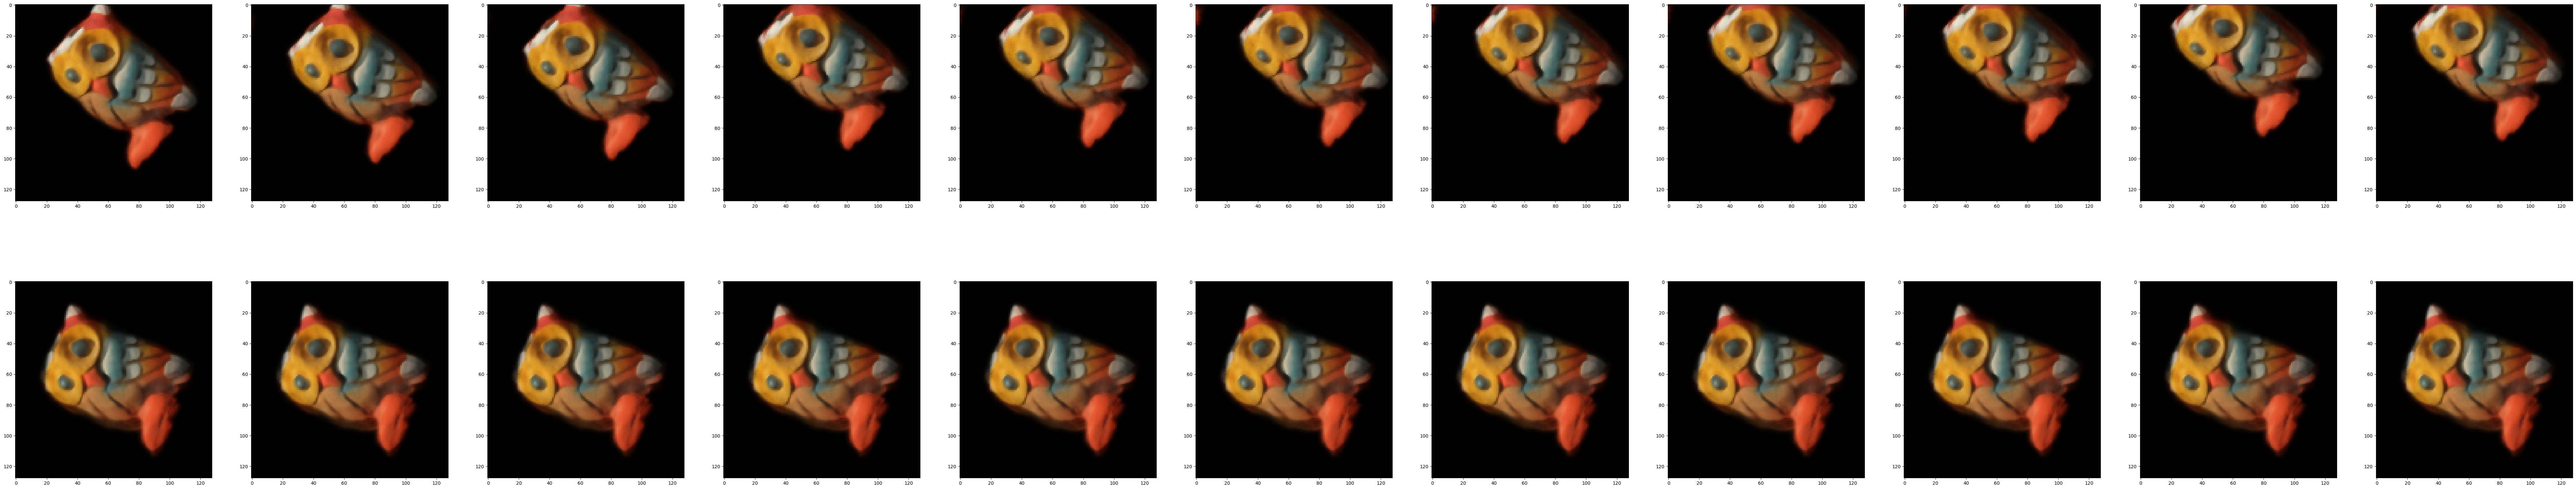

In [13]:
# plot rendered images
target_img_np = (target_img * 255).cpu().numpy().astype(np.uint8)
fig, axs = plt.subplots(2, len(overlay_frames))
fig.set_size_inches(100, 20)
for i in range(len(fine_patches)):
    axs[0, i].imshow(overlay_frames[i][...,[2,1,0]])
    axs[1, i].imshow(target_img_np[...,[2,1,0]])
plt.show()

In [ ]:
# save the predicted poses
predicted_poses_save = np.stack(predicted_poses, axis=0)
np.save('predicted_poses.npy', predicted_poses_save)


# Render Image using NERF

### Current :
target image: rendered_img_4.png

input image: rendered_img_6_noised.png, noise 6

In [20]:
cam_pose_dir = "../instant-nsr-pl/datasets/fixed_poses/"

input_poses = [] 
for poses_fpath in os.listdir(cam_pose_dir):
    pose_tmp = np.loadtxt(os.path.join(cam_pose_dir, poses_fpath))
    input_poses.append(inv_RT(RT_opengl2opencv(pose_tmp)))

n_poses = len(input_poses)
print(f"Loaded {len(input_poses)} poses from {cam_pose_dir}")

input_poses_ts = torch.from_numpy(np.array(input_poses)).float()
# H, W = target_img.shape[1], target_img.shape[0]
H, W= 128, 128  
z_near, z_far = 0.2, 2.4 # line 308 in dataset_mvdiff.py
focal = torch.tensor(W/2, dtype=torch.float32, device=device) # TODO, is this right??

# target_img = torch.from_numpy(target_img).float().to(device)
# target_img_flatten =torch.reshape(target_img, [-1, 3]) # normalized

Loaded 9 poses from ../instant-nsr-pl/datasets/fixed_poses/


In [14]:
render_pose_0 = torch.from_numpy(np.array(predicted_poses[0])).float()

input_pose_batch =render_pose_0.repeat(10, 1, 1)
SE3_noise = generate_SE3_noise(input_pose_batch, amplitude=0.2)

noisy_poses = compose_pair(input_pose_batch, SE3_noise)

In [15]:
def create_image(patch):
    image = np.zeros((128, 128, 3))
    image[48:80, 48:80, :] = patch
    image = (image * 255.0).astype(np.uint8)
    return image

config = {
        'input': '.',
        'output':'./outputs',
        }

# Rendering.
# overlay_frames = []
# n_poses = len(predicted_poses)

# render_poses = torch.from_numpy(np.array(predicted_poses)).float()
# print("render_poses", render_poses.shape)

render_poses = noisy_poses
n_poses = render_poses.shape[0]
# render_rays = gen_rays(render_poses, W, H, focal, z_near, z_far)
# print(f'shape of rendered rays from inerf {render_rays.shape}')
render_rays = gen_rays_from_a_view(render_poses, W, H)
print(f'shape of rendered rays from NEUS {render_rays.shape}')
render_rays = render_rays.to(device='cuda')
with torch.no_grad():
    print("Rendering", n_poses * H * W, "rays")
    all_rgb_fine = []
    for rays in tqdm.tqdm(torch.split(render_rays.view(-1, render_rays.shape[-1]), 100, dim=0)):
        render_out = renderer.render(
                                    rays[..., 0:3], 
                                    rays[..., 3:6], 
                                    z_near, 
                                    z_far, 
                                    cos_anneal_ratio=get_cos_anneal_ratio(0), 
                                    background_rgb=None
                                    ) # TODO check get_cos_anneal_ratio(input)

        rgb = render_out['color_fine']
        all_rgb_fine.append(rgb)
    rgb_fine = torch.cat(all_rgb_fine)
    frames = (rgb_fine.view(n_poses, H, W, 3).cpu().numpy() * 255).astype(
        np.uint8
    )

shape of rendered rays from NEUS torch.Size([10, 16384, 6])
Rendering 163840 rays


  0%|          | 0/1639 [00:00<?, ?it/s]

100%|██████████| 1639/1639 [00:28<00:00, 57.40it/s]


In [33]:
os.makedirs(config['output'], exist_ok=True)
for ii in range(frames.shape[0]):
    rendered_img_path = os.path.join(config['output'], f'rendered_img_{ii}.png')
    cv2.imwrite(rendered_img_path, frames[ii])

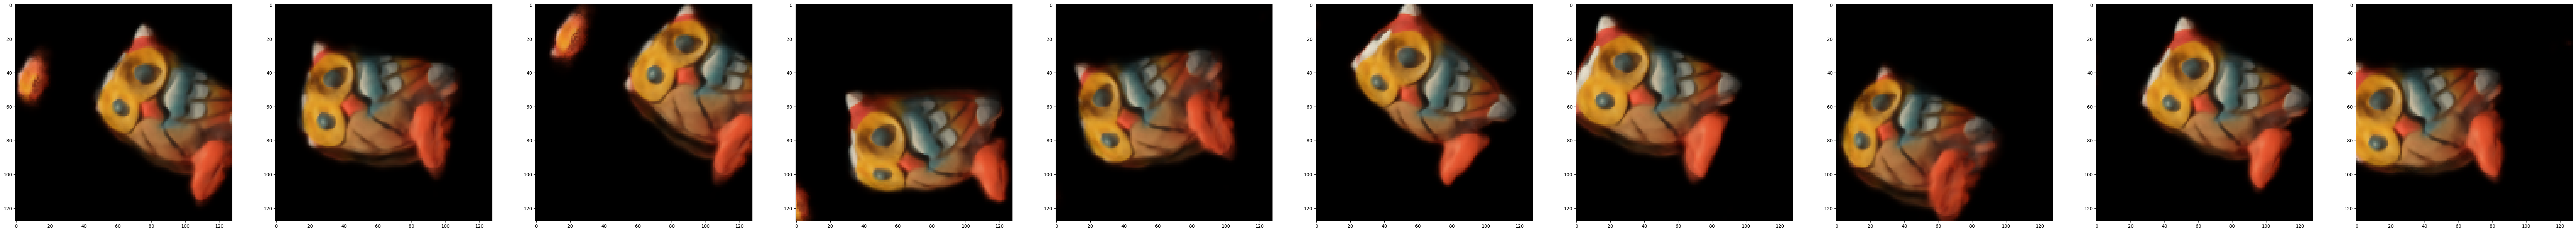

In [16]:
fig, axs = plt.subplots(1,n_poses)
fig.set_size_inches(100, 20)
for i in range(n_poses):
    axs[i].imshow(frames[i][...,[2,1,0]])
    # axs[1, i].imshow(target_img_np[...,[2,1,0]])


In [21]:
np.save(f'./SE3_noise_{0}.npy', SE3_noise)
np.save(f'./noisy_poses_{0}.npy', noisy_poses)
